# YouTube Video Category Classification

Pada notebook ini, kita akan mulai untuk membuat model *machine learning* yang akan mengklasifikasikan kategori video YouTube berdasarkan **judul** dan **deskripsi** video. Data yang akan digunakan adalah data [video trending YouTube Indonesia](https://www.kaggle.com/syahrulhamdani/indonesias-trending-youtube-video-statistics).

````{tip}
Setelah selesai mengunduh, sangat disarankan untuk diletakkan dalam folder `data` yang sejajar dengan notebook ini.
```bash
|- modelling.ipynb
|- data
    |- youtube
        |- trending.csv
        |- category.json
```
````


## Import Libraries

Pertama, kita akan import beberapa library yang akan digunakan pada notebook ini.

In [1]:
from textwrap import wrap

import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

/Users/bitlabsinstructor/.pyenv/versions/3.8.11/envs/bitlabs-webinar/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Data Loading

Untuk `trending.csv`, kita bisa langsung membaca data tersebut menggunakan `pandas`. Khusus untuk `category.json`, kita akan definisikan fungsi berikut untuk membantu kita membaca data kategori video.

```python
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }
```

```{note}
Karena alasan teknis, kita hanya akan menggunakan data video trending dari bulan Juli sampai Desember saja.
```

In [2]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }

In [3]:
category_dict = get_category_dict("data/category.json")

In [4]:
trending = pd.read_csv("./data/trending.csv", parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
    display(trending.head())

publish_time                channel_id  \
0 2021-02-05 09:00:34+00:00  UCEf_Bc-KVd7onSeifS3py9g   
1 2021-02-04 15:54:08+00:00  UCYEa4_MC7OFjcWrO6SO-u8g   
2 2021-02-06 03:00:22+00:00  UCu12RxQjRQyh79YBYvEDkOg   
3 2021-02-05 20:26:08+00:00  UCCuzDCoI3EUOo_nhCj4noSw   
4 2021-02-03 23:14:54+00:00  UC14UlmYlSNiQCBe9Eookf_A   

                                               title  \
0                        aespa 에스파 'Forever (약속)' MV   
1  [FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...   
2     CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12)   
3                        With Windah Basudara & Hans   
4  🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...   

                                         description  thumbnail_url  \
0  aespa's new single "Forever" is out!\nListen a...            NaN   
1  Jakarta, https://www.tvonenews.com - Ketua umu...            NaN   
2  Road Party Season 2: Cabriolet Challenge\n\nEp...            NaN   
3  Join this channel to get access to perks:\nhtt...            NaN   
4  With just two minutes to play, Barça looked to...            NaN   

   thumbnail_width  thumbnail_height            channel_name  \
0              NaN               NaN                  SMTOWN   
1              NaN               NaN  Indonesia Lawyers Club   
2              NaN               NaN                Motomobi   
3              NaN               NaN                      yb   
4              NaN               NaN            FC Barcelona   

                                                tags  category_id live_status  \
0                                                NaN           10        none   
1  ['tvone', 'tv one', 'tvonenews', 'indonesia la...           25        none   
2  ['MotoMobi', 'Mobil', 'motor', 'review', 'indo...            2        none   
3                                                NaN           20        none   
4  ['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...           17        none   

                                         local_title  \
0                        aespa 에스파 'Forever (약속)' MV   
1  [FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...   
2     CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12)   
3                        With Windah Basudara & Hans   
4  🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...   

                                   local_description  duration dimension  \
0  aespa's new single "Forever" is out!\nListen a...    PT5M7S        2d   
1  Jakarta, https://www.tvonenews.com - Ketua umu...  PT42M30S        2d   
2  Road Party Season 2: Cabriolet Challenge\n\nEp...  PT46M43S        2d   
3  Join this channel to get access to perks:\nhtt...  PT45M59S        2d   
4  With just two minutes to play, Barça looked to...   PT5M12S        2d   

  definition  caption  license_status allowed_region blocked_region  \
0         hd     True            True            NaN            NaN   
1         hd    False            True            NaN            NaN   
2         hd    False            True            NaN            NaN   
3         hd    False            True            NaN            NaN   
4         hd    False            True            NaN            NaN   

        view      like  dislike  favorite  comment  \
0  7806846.0  857902.0  24078.0         0  94961.0   
1   885038.0    6765.0   1263.0         0   6365.0   
2   889708.0   47895.0    532.0         0   8785.0   
3  1006854.0   91973.0   3967.0         0  12957.0   
4  6275035.0  218131.0   4289.0         0  12799.0   

                     trending_time  
0 2021-02-07 05:46:51.832614+00:00  
1 2021-02-07 05:46:51.832649+00:00  
2 2021-02-07 05:46:51.832664+00:00  
3 2021-02-07 05:46:51.832678+00:00  
4 2021-02-07 05:46:51.832730+00:00

In [5]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-02-07 05:46:51.832614+0000', tz='UTC')
end_date = Timestamp('2021-12-06 06:01:25.828896+0000', tz='UTC')


Bisa kita lihat bahwa data video trending dimulai dari bulan **Februari** sampai **Desember**. Untuk itu, kita akan *drop* data dari bulan **Februai sampai Juni**.

In [6]:
filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date = Timestamp('2021-12-06 06:01:25.828896+0000', tz='UTC')


In [7]:
num_videos = filtered_trending.shape[0]
print(f"{num_videos = }")

num_videos = 31600


Terdapat $31.600$ video yang masuk daftar trending setiap harinya dari bulan Juli sampai Desember. Selanjutnya, kita akan lakukan eksplorasi data terlebih dahulu sebelum mulai membuat model *machine learning*.

Selanjutnya, mari kita lihat bagaimana distribusi *missing value* pada masing-masing kolom.

In [8]:
filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31600 entries, 21322 to 52921
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   publish_time       31600 non-null  datetime64[ns, UTC]
 1   channel_id         31600 non-null  object             
 2   title              31600 non-null  object             
 3   description        30194 non-null  object             
 4   thumbnail_url      0 non-null      float64            
 5   thumbnail_width    0 non-null      float64            
 6   thumbnail_height   0 non-null      float64            
 7   channel_name       31600 non-null  object             
 8   tags               27542 non-null  object             
 9   category_id        31600 non-null  int64              
 10  live_status        31600 non-null  object             
 11  local_title        31600 non-null  object             
 12  local_description  30194 non-null  object 

Dari informasi di atas, ada beberapa video yang kolom deskripsinya kosong. Untuk alasan *modeling* nanti, kita akan hapus video yang tidak memiliki teks deskripsi.

In [9]:
filtered_trending.dropna(subset=["description"], inplace=True)

## Exploratory Data Analysis

Pertama, karena setiap hari, bahkan setiap beberapa jam, daftar trending di YouTube selalu ada pembaruan, mari kita lihat jumlah video dari hari per hari. Langkah-langkahnya yaitu:
* Kelompokkan data berdasarkan tanggal per hari
* Hitung jumlah video pada tanggal tersebut

In [10]:
trending_by_date = filtered_trending.groupby(
    filtered_trending.trending_time.dt.date
)
num_trending_per_day = trending_by_date.trending_time.count()
print("Number of videos in trending per day:", num_trending_per_day.unique())

Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183]


Jadi, setiap harinya, terdapat **200 video** yang masuk dalam daftar trending YouTube dari tanggal 1 Juli sampai 6 Desember.


### Trending Duration

Video masuk trending YouTube kadang kala juga bisa bertahan beberapa hari. Lama bertahannya video dalam daftar trending ini mungkin disebabkan oleh beberapa faktor seperti jumlah like, jumlah view, kecepatan kenaikan kedua metrik tersebut, dan lainnya. Mari kita lihat berapa lama durasi suatu video bertahan dalam trending YouTube.

In [11]:
trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

trending_duration.head(10)

title  trending_duration  \
0                  Måneskin - Beggin' (Lyrics/Testo)                 30   
1                        Måneskin - Beggin' (Lyrics)                 30   
2       The Kid LAROI, Justin Bieber - Stay (Lyrics)                 22   
3  Happy Asmara - Lemah Teles (Official Music Liv...                 21   
4  WONDERLAND INDONESIA by Alffy Rev (ft. Novia B...                 21   
5  DENNY CAKNAN FT. NDARBOY GENK - MENDUNG TANPO ...                 20   
6  Join the BTS #PermissiontoDance Challenge only...                 20   
7  MERINDING GUE DENGER INI, GOKIL‼️ SEREM ABIS‼️...                 20   
8  Create your own short to Shivers using #Sheera...                 20   
9      BTS (방탄소년단) 'Permission to Dance' Official MV                 20   

               trending_start_date               trending_last_date  
0 2021-07-06 06:01:08.609842+00:00 2021-08-14 06:01:09.572758+00:00  
1 2021-07-09 06:03:40.293908+00:00 2021-09-29 06:00:48.508222+00:00  
2 2021-08-07 06:00:58.727254+00:00 2021-11-02 06:00:52.042819+00:00  
3 2021-07-19 06:02:49.428626+00:00 2021-08-08 06:01:02.782146+00:00  
4 2021-08-18 06:00:55.039010+00:00 2021-09-07 06:00:48.332429+00:00  
5 2021-07-28 06:00:52.529306+00:00 2021-08-16 06:01:24.371425+00:00  
6 2021-08-07 06:00:58.726624+00:00 2021-08-26 06:00:52.511071+00:00  
7 2021-07-02 06:01:02.071087+00:00 2021-07-21 06:01:23.252876+00:00  
8 2021-10-26 06:00:53.187313+00:00 2021-11-14 06:01:05.587878+00:00  
9 2021-07-10 06:01:04.439918+00:00 2021-07-29 06:00:56.665583+00:00

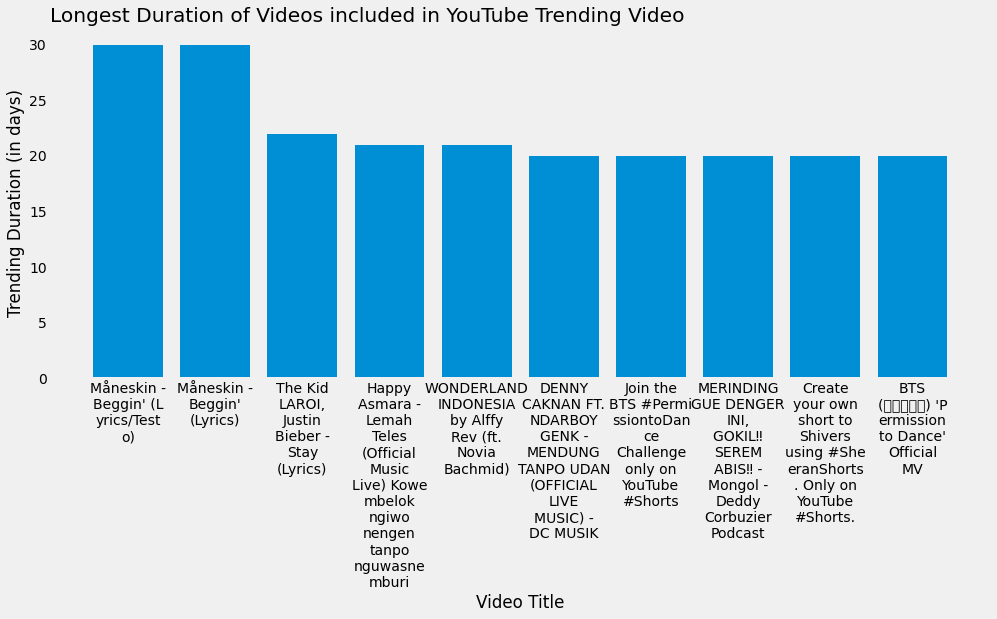

In [12]:
plt.figure(figsize=(15, 6))
plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
    trending_duration.trending_duration[:10]
)
plt.title("Longest Duration of Videos included in YouTube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

```{tip}
Silakan eksplor lebih jauh lagi untuk durasi sebuah video bertahan dalam daftar trending dalam hal kategori video, channel, dan lainnya.
```


### Most Viewed, Liked, and Disliked Video

Metrik ini tentu sangat umum dan dijunjung tinggi oleh para kreator konten YouTube. Dengan metrik tersebut, kita juga bisa membuat *YouTube Rewind 2021* versi sederhana kita sendiri.

In [13]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...   503651.0   822845.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...  1398186.0  1398186.0   
...                                                       ...        ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      1011999.0  1885538.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...  7.171452e+05   3585726.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...  1.398186e+06   1398186.0   
...                                                          ...         ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      1.567651e+06  10973554.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...    6952.0    9144.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...   44228.0   44228.0   
...                                                      ...       ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      127578.0  186596.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...    8436.200000    42181.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...   44228.000000    44228.0   
...                                                           ...        ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      165558.857143  1158912.0   
🥰 New Gadgets & Versatile Utensils

Jika kita lihat data di atas, ada beberapa video yang jumlah minimal dan maksimum `view`, `like`, maupun `dislike` yang berbeda. Ini bisa saja dikarenakan video tersebut yang bertahan beberapa hari dalam trending, seperti video `"Emosi Rico Simanjutak" Saat ...` yang dimulai dengan jumlah `view` 72.434 pada awal masuk trending dan pada hari terakhir dalam trending mencapai jumlah `view` 116.310.

Sekarang, mari kita lihat jumlah maksimal `view`, `like`, dan `dislike` dari video teratas masing-masing tersebut dan bandingkan dengan pada saat awal masuk trending.

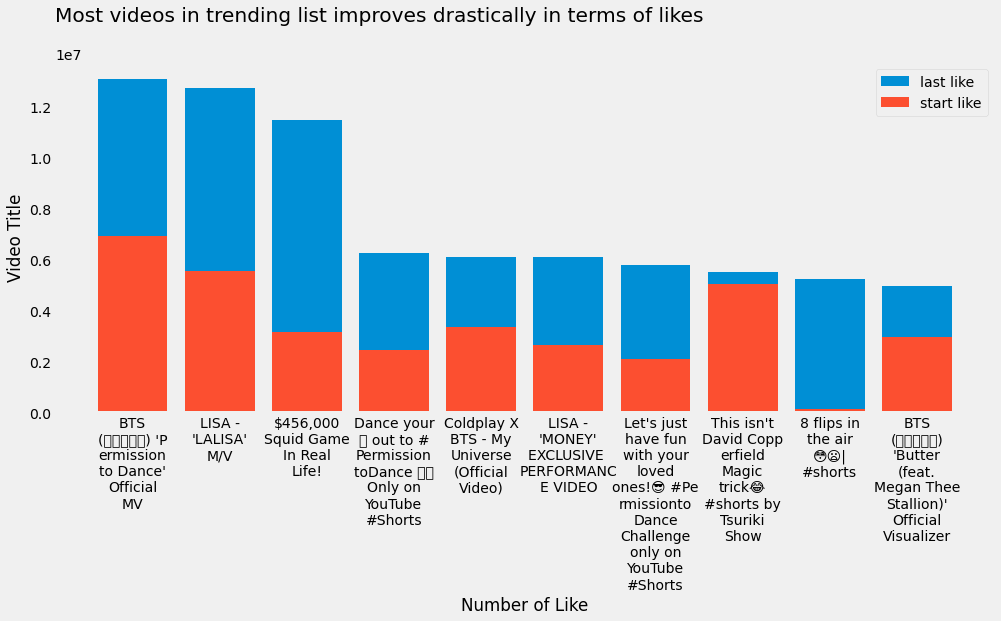

In [14]:
top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="last like"
)
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="start like"
)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

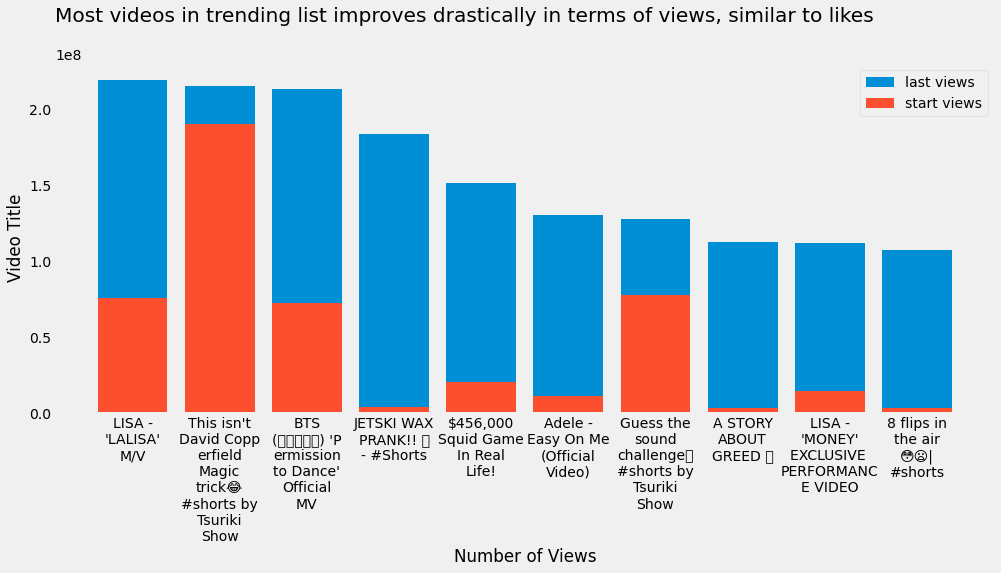

In [15]:
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="last views"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="start views"
)
plt.title("Most videos in trending list improves drastically in terms of views, similar to likes", loc="left", y=1.1)
plt.xlabel("Number of Views")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

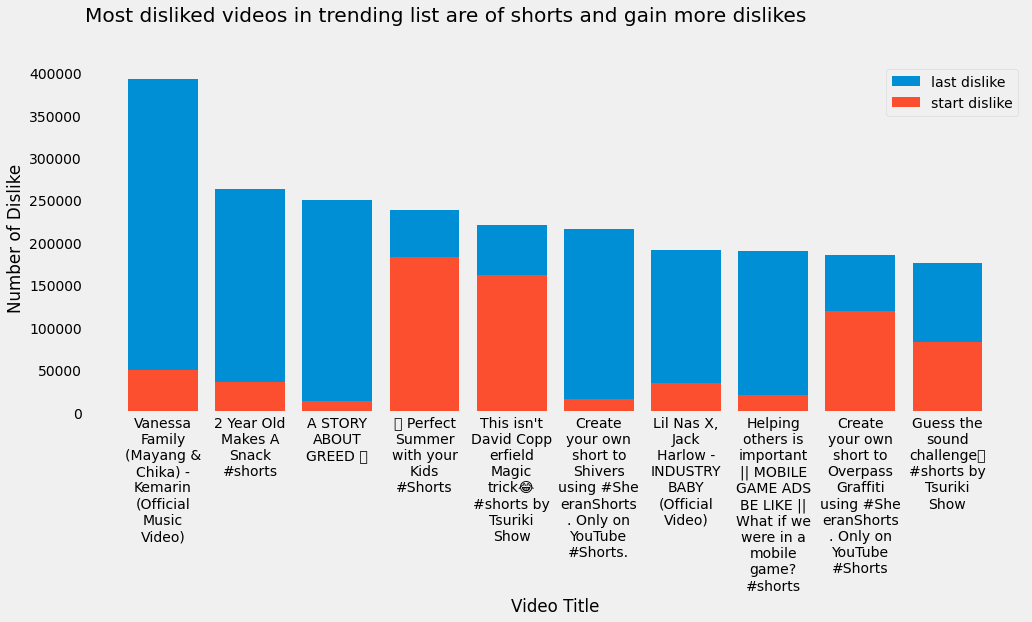

In [16]:
top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["max"],
    label="last dislike"
)
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["min"],
    label="start dislike"
)
plt.title("Most disliked videos in trending list are of shorts and gain more dislikes", loc="left", y=1.1)
plt.ylabel("Number of Dislike")
plt.xlabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

```{tip}
Kamu bisa melakukan eksplorasi lebih jauh lagi, seperti:
* most viewed, liked, and disliked channels
* video age from published until it's trending
* dan lainnya
```

## Data Preparation

Data judul dan deskripsi yang akan kita proses nantinya termasuk ke dalam *unstructured data* atau teks. Pemrosesan data teks ini termasuk ke dalam bidang NLP (*Natural Language Processing*)

```{figure} assets/gif/nlp-overview.gif
:name: nlp-overview
:alt: Overview NLP

Aplikasi *Natural Langauge Processing* ([ref](https://s3.amazonaws.com/codecademy-content/courses/NLP/Natural_Language_Processing_Overview.gif))
```

### Language Detection

Setelah melakukan eksplorasi, sekarang saatnya kita menyiapkan data yang akan digunakan untuk mengklasifikaskan kategori video, yaitu `title` dan `description`.

```{attention}
Kita hanya akan menggunakan video yang judul dan deskripsinya menggunakan bahasa Indonesia.
```

Karena kita hanya akan menggunakan teks berbahasa Indonesia, kita perlu menyaring mana yang berbahasa Indonesia dan mana yang bukan. Ada banyak *library* yang bisa kita gunakan, salah satunya adalah [`spacy`](https://spacy.io/). Tapi, karena alasan teknis, kita hanya akan menggunakan *library* yang lebih sederhana, yaitu [`langdetect`](https://github.com/Mimino666/langdetect).

````{note}
Jika kamu belum menginstall `langdetect`, install dengan perintah berikut:
```bash
pip install langdetect
```
````

Sebagai contoh, perhatikan sampel judul dan deskripsi video berikut.

In [17]:
sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

title  \
36912            REAKSI ORANG JEPANG NYOBAIN JUS ALPUKAT   
38941  Pengamen yang bisa mainin lagu ini gue kasih 1...   
48089    TREASURE - WEB DRAMA '남고괴담' CHARACTER INTERVIEW   
24766    (YB & Heiakim) Hello Goodbye - Sungha Jung X YB   
50307  Memecahkan Misteri Tantangan 1000 Kunci #2 Mul...   
47844  aespa 에스파 'Savage' Squid Game ver. Dance Practice   
46357  PMPL SEA Championship S4 | Superweekend 3 Day ...   
23245  DAY6 (Even of Day) "Right Through Me(뚫고 지나가요)"...   
24599  DJ SETIAP YANG KU LAKUKAN  UNTUK DIRIMU VIRAL ...   
27364    EP. 24 : Nekat Riding ke Area Rawan di Colombia   

                                             description  
36912  Begini reaksi Yoshi pertama kali nyobain jus a...  
38941  Pengamen sekarang keren-keren banget alatnya l...  
48089  남고괴담 비하인드 스토리 구매하기\nhttps://weverseshop.onelin...  
24766  (YB & Heiakim) Hello Goodbye - Sungha Jung X Y...  
50307  Jika ada brankas tertutup di depanmu, kau past...  
47844  'Savage' MV hits 100M views!\nThank you so muc...  
46357  SUPERWEEKEND TERAKHIR PENENTUAN 1 TIKET PERTAM...  
23245  DAY6 (Even of Day) "Right Through Me(뚫고 지나가요)"...  
24599  ----------------------------------------------...  
27364  #WheelStory #MarioIroth #HondaAfricaTwin\n\nSe...

In [18]:
sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [19]:
with pd.option_context("display.max_colwidth", 100):
    display(sample[["title", "title_lang", "description", "desc_lang"]])

title  \
36912                                                REAKSI ORANG JEPANG NYOBAIN JUS ALPUKAT   
38941                   Pengamen yang bisa mainin lagu ini gue kasih 100 dollar | #Nantangin   
48089                                        TREASURE - WEB DRAMA '남고괴담' CHARACTER INTERVIEW   
24766                                        (YB & Heiakim) Hello Goodbye - Sungha Jung X YB   
50307                          Memecahkan Misteri Tantangan 1000 Kunci #2 Multi DO Challenge   
47844                                      aespa 에스파 'Savage' Squid Game ver. Dance Practice   
46357  PMPL SEA Championship S4 | Superweekend 3 Day 1 | FULL TEAM INDONESIA DI SUPERWEEKEND   
23245                               DAY6 (Even of Day) "Right Through Me(뚫고 지나가요)" LIVE CLIP   
24599          DJ SETIAP YANG KU LAKUKAN  UNTUK DIRIMU VIRAL TIKTOK BAHAGIA SLOW BEAT SYAHDU   
27364                                        EP. 24 : Nekat Riding ke Area Rawan di Colombia   

      title_lang  \
36912         id   
38941         id   
48089         en   
24766         so   
50307         id   
47844         fr   
46357         en   
23245         en   
24599         id   
27364         id   

                                                                                               description  \
36912  Begini reaksi Yoshi pertama kali nyobain jus alpukat! \nKalo di Jepang, alpukat dimakannya pake ...   
38941  Pengamen sekarang keren-keren banget alatnya lengkap.\nShoutout to pengamen-pengamen Bandung.\n\...   
48089  남고괴담 비하인드 스토리 구매하기\nhttps://weverseshop.onelink.me/BZSY/9595f182 \n\n#TREASURE #트레저 #남고괴담 #TheMy...   
24766  (YB & Heiakim) Hello Goodbye - Sungha Jung X YB\n\nTuning : Standard\n\nOriginal : https://youtu...   
50307  Jika ada brankas tertutup di depanmu, kau pasti ingin tahu apa isinya! Pahlawan kita juga sangat...   
47844  'Savage' MV hits 100M views!\nThank you so much for your love and support 😘\n\nListen and downlo...   
46357  SUPERWEEKEND TERAKHIR PENENTUAN 1 TIKET PERTAMA MENUJU PMGC! Seteleh 2 hari Weekdays yang cukup ...   
23245  DAY6 (Even of Day) "Right Through Me(뚫고 지나가요)" LIVE CLIP\n\nListen to DAY6 (Even of Day) "Right ...   
24599  -------------------------------------------------------------\n Judul : DJ SETIAP YANG KU LAKUKA...   
27364  #WheelStory #MarioIroth #HondaAfricaTwin\n\nSetelah Ecuador negara selanjutnya yang saya jelajah...   

      desc_lang  
36912        id  
38941        id  
48089        en  
24766        en  
50307        id  
47844        en  
46357        id  
23245        en  
24599        id  
27364        id

```{note}
Perhatikan bahwa sebelum `langdetect.detect`, `title` dan `deskripsi` dijadikan *lowercase*. Ini dilakukan supaya `langdetect` dapat mendeteksi bahasa secara maksimal.
```

Ada beberapa kasus yang mungkin terjadi untuk deteksi bahasa pada judul dan deskripsi di atas:
* Judul berbahasa Indonesia, sedangkan deskripsi dideteksi sebagai bahasa asing (yang mungkin seharusnya bahasa Indonesia)
* Deksripsi dideteksi sebagai bahasa Indonesia, sedangkan judul berbahasa asing (yang mungkin seharusnya bahasa Indonesia)
* Baik judul atau deskripsi dideteksi sebagai bahasa asing, yang seharusnya salah satu atau keduanya berbahasa Indonesia

Untuk kemungkinan ketiga, kita tidak akan menggunakan video yang judul dan deskripsinya dideteksi sebagai bahasa asing, meskipun seharusnya salah deteksi.  Sekarang, mari kita deteksi bahasa untuk semua video dalam `filtered_trending`.

Pertama, kita akan buat fungsi yang akan mendeteksi bahasa dari sebuah teks sebagai berikut.

```python
def detect_language(text):
    """Detect language of the `text`."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return
```

In [20]:
def detect_language(text):
    """Detect language of the `text`."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return

In [21]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

In [22]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

title title_lang  \
21322                 NCT DREAM 엔시티 드림 'Hello Future' MV         it   
21323              PART 3 // SUTRISNO DAN ENDANG BAHAGIA         de   
21324  This isn't David Copperfield Magic trick😂 #sho...         en   
21325   Rizky Billar - Pemimpinmu | Official Music Video         en   
21326  Ini Pengakuan Pengemudi Pajero usai Rusak dan ...         id   
...                                                  ...        ...   
52916  ARSY DAN THALIA ONSU DUET SAMPAI BIKIN RAFFI A...         de   
52918    Beli barang aneh yang dijual ONLINE Episode 20!         id   
52919  Layangan Putus | Highlight EP02 Senyum Bahagia...         id   
52920               PAULA LEMES , GA BISA NGOMONG APA2..         hu   
52921  PRANK RICIS & TEUKU RYAN YG LAGI HONEYMOON! NG...         en   

                                             description desc_lang  
21322  NCT DREAM's 1st Album Repackage "Hello Future"...        en  
21323  Find me on sosial media :\n\nInstagram : https...        en  
21324  Thank you for watching.\nSubscribe to Tsuriki ...        en  
21325  Rizky Billar - Pemimpinmu | Official Music Vid...        id  
21326  Polisi menangkap pengemudi SUV yang merusak da...        id  
...                                                  ...       ...  
52916  Gemes! Arsy dan Thalia Putri Onsu duet nyanyi ...        id  
52918  Banyak lap nya.\n\nDapatkan Betadine Cold Defe...        id  
52919  Yuk tonton full episodenya, GRATIS melalui app...        id  
52920  =================================\r\n\r\nSocia...        id  
52921  Hi baby!\n\nDi video ini aku akan ajak kalian ...        en  

[30194 rows x 4 columns]

Setelah kita selesai mendeteksi bahasa pada `title` dan `description`, langkah selanjutnya adalah membuang data yang `title` atau `description` bukan `id`, yaitu tidak berbahasa Indonesia.

In [23]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
    display(indo_trending.sample(10))

publish_time                channel_id  \
44745 2021-10-18 05:30:12+00:00  UCVcdUPUEMqqRibLpx8HL3kw   
52118 2021-11-23 11:34:47+00:00  UC0rzsIrAxF4kCsALP6J2EsA   
25786 2021-07-22 12:00:11+00:00  UCVvMtyC5TSZT0Ykq04mc2ow   
47503 2021-11-01 09:24:26+00:00  UCsRCIwkrez96kJGZRjLN6UA   
49567 2021-11-13 14:16:39+00:00  UCxbyLjNoi-54B3mcVoiOQow   
32259 2021-08-23 02:30:13+00:00  UC3UuIeus9q6VmfZGEz7W7mg   
33826 2021-08-30 02:00:06+00:00  UCCgrv_q3Z5JDlUj5gq0GZzA   
51919 2021-11-29 09:00:02+00:00  UCwaNp8vD8ocVTbIJQt-Q3Dw   
37229 2021-09-14 03:00:06+00:00  UCNrN1jrDHKE4lCD-BKa9pog   
27476 2021-07-28 00:30:11+00:00  UCTsELnrXGcGZKpU6CiVaQGg   

                                                   title  \
44745  DIHIPNOTIS‼ RICIS UNGKAP KATA HATI YANG BUAT R...   
52118         Paranormal Experience: Masa Suram di Kosan   
25786                       UN1TY - 'BABY' M/V (Eng Sub)   
47503  PERCIL Terbaru November 2021 gak kuat neng Pem...   
49567  No Cut No Edit Unboxing Souvenir Resepsi Ricis...   
32259  Esa Risty feat. Wandra - Mister Mendem (Offici...   
33826  Bergemuruh !!! Lihat Dari Dekat Pesawat Tempur...   
51919  Membuat Jetbus 2+ Paling Segar | Vlog Garasi P...   
37229  YUSUF BISA LIHAT HANTU DI RUMAH RICIS.. Semua ...   
27476  Mendung Tanpo Udan | Cover Koplo Version | Sab...   

                                             description  thumbnail_url  \
44745  #riaricis #teukuryan\n\nFollow Social Media UY...            NaN   
52118  Do You See What I See : https://www.youtube.co...            NaN   
25786  #UN1TYBaby #UN1TY #1IDEntertainment\n\nA new b...            NaN   
47503  Percil terbaru 2021 lucu, Cak PERCIL terbaru G...            NaN   
49567  Follow Instagram :\n@atiikazzz : https://www.i...            NaN   
32259  Esa Risty feat. Wandra - Mister Mendem (Offici...            NaN   
33826  Bergemuruh !!! Lihat Dari Dekat Pesawat Tempur...            NaN   
51919  sadar ngga jetbus 2 itu ganteng banget, ngga l...            NaN   
37229  Contact business : Ricismanagement@gmail.com (...            NaN   
27476  Judul : Mendung Tanpo Udan\nKukuh Prasetya Kud...            NaN   

       thumbnail_width  thumbnail_height            channel_name  \
44745              NaN               NaN             Uya Kuya TV   
52118              NaN               NaN            Raditya Dika   
25786              NaN               NaN                   UN1TY   
47503              NaN               NaN               Jawanesia   
49567              NaN               NaN               Tri Atika   
32259              NaN               NaN  SENTRA MUSIK INDONESIA   
33826              NaN               NaN           Raja Video ID   
51919              NaN               NaN               Mas Wahid   
37229              NaN               NaN             Rumah Ricis   
27476              NaN               NaN               Koplo Ind   

                                                    tags  category_id  \
44745  ['uya kuya', 'nino kuya', 'cinta kuya', 'astri...           24   
52118                                   ['raditya dika']           22   
25786  ['1IDMusic', 'Pencarian Bakat', 'Boyband', 'Kp...           24   
47503  ['percil yudho', 'peye', 'Precil', 'Percil', '...           22   
49567  ['ria ricis', 'ria ricis nikah', 'teuku ryan',...           24   
32259  ['sentra musik indonesia', 'lagu jawa', 'koplo...           10   
33826  ['pesawat', 'pesawat terbang', 'kapal terbang'...           19   
51919  ['berburu mobil impian', 'mas wahid', 'tips me...            2   
37229  ['Rumah', 'Ricis', 'ria', 'ricis', 'official',...           24   
27476  ['Mendung Tanpo udan', 'mendung tanpo udan', '...           10   

      live_status                                        local_title  \
44745        none  DIHIPNOTIS‼ RICIS UNGKAP KATA HATI YANG BUAT R...   
52118        none         Paranormal Experience: Masa Suram di Kosan   
25786        none                       UN1TY - 'BABY' M/V (Eng Sub)   
47503        none  

### Feature Extraction

Selanjutnya, kita akan membuang semua fitur/kolom yang tidak diperlukan. Dalam hal ini, kita hanya akan memerlukan `title`, `descrption`, dan `category_id`. Sehingga, kolom lainnya akan dibuang.

In [24]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)

In [25]:
data

title  \
0       Rizky Billar - Pemimpinmu | Official Music Video   
1      Ini Pengakuan Pengemudi Pajero usai Rusak dan ...   
2      Aksi Demo Tolak Kedatangan Jokowi di Kendari B...   
3      PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...   
4      PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...   
...                                                  ...   
17750  Nazia Marwiana - Kehadiran Cinta (Official Mus...   
17751  ARSY DAN THALIA ONSU DUET SAMPAI BIKIN RAFFI A...   
17752    Beli barang aneh yang dijual ONLINE Episode 20!   
17753  Layangan Putus | Highlight EP02 Senyum Bahagia...   
17754               PAULA LEMES , GA BISA NGOMONG APA2..   

                                             description  category_id  
0      Rizky Billar - Pemimpinmu | Official Music Vid...           10  
1      Polisi menangkap pengemudi SUV yang merusak da...           25  
2      Tanggal Tayang: 30/06/2021\n\nProgram berita h...           25  
3      Assalamualaikum gaeess..! sudah nonton video s...           15  
4      Talk show malam yang akan memberikan informasi...           24  
...                                                  ...          ...  
17750  Official Music Live from Nazia Marwiana - Keha...           10  
17751  Gemes! Arsy dan Thalia Putri Onsu duet nyanyi ...           24  
17752  Banyak lap nya.\n\nDapatkan Betadine Cold Defe...           28  
17753  Yuk tonton full episodenya, GRATIS melalui app...            1  
17754  =================================\r\n\r\nSocia...           24  

[17755 rows x 3 columns]

### Duplicates

Jika kita perhatikan secara teliti, kita akan temukan bahwa ada beberapa `title` ataupun `desription` yang duplikat. Hal in dikarenakan adanya kemungkinan sebuah video masuk dalam daftar trending pada hari yang berbeda. Untuk alasan *fairness*, kita akan membuang beberapa duplikat tersebut.

In [26]:
data.drop_duplicates(subset="title", inplace=True)

In [27]:
data.reset_index(drop=True, inplace=True)

In [28]:
data.shape

(3650, 3)

Setelah membuang beberapa duplikat, hanya tersisa **3643** baris data saja yang akan kita gunakan pada fase *modeling*.

### Feature Engineering

Kita tahu bahwa biasanya kreator konten suka menggunakan emoji di judul ataupun deskripsi video mereka. Emoji ini mungkin bisa menggambarkan judul dan deskripsi. Oleh karena itu, kita akan coba mengubah emoji tersebut ke dalam bentuk teks menggunakan library `emoji`.

````{note}
Silakan install terlebih dahulu library `emoji` dengan perintah berikut.
```bash
pip install emoji
```
````

Sebelum itu, mari kita ada berapa judul yang menggunakan emoji di dalamnya.

In [29]:
list_emoji = [e for e in emoji.UNICODE_EMOJI.get("en")]

count = 0
for em in list_emoji:
    for title in data.title:
        if em in title:
            count += 1
print("How many titles use emoji?", count)

How many titles use emoji? 524


Ternyata ada 538 video yang judul nya menggunakan emoji. Kita akan buat fungsi untuk menerjemahkan emoji di dalam judul sebagai berikut.

```python
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text
```

In [30]:
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text

In [31]:
data["title_emoji"] = data.title.apply(demojize)

Mari kita lihat beberapa sampel judul yang menggunakan emoji dan bagaimana bentuk representasi teksnya.

In [32]:
title_with_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]

In [33]:
with pd.option_context("display.max_colwidth", 100):
    display(data.loc[title_with_emoji_idx])

title  \
34    Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih...❤   
79       BIKIN CEWEK TERPESONA 😍 Aksi Heroik Driver Muda Menolong Sopir Yang Kesulitan di Sitinjau Lauik   
81                                         15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN ✅ ✅ ✅   
147                                            WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast   
147                                            WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast   
...                                                                                                  ...   
3534                                  MAKIN PSIKOPAT NIH ORG‼️🤣 - RADITYA DIKA - Deddy Corbuzier Podcast   
3536                                         AKHIRNYA KETEMU KELUARGA!! SURPRISE KASIH HADIAH, TERHARU 😭   
3538                                            Bibi Korea sakit, obatnya makan rasa pedas Indonesia!!🔥🔥   
3578                   💚Indonesian NCTzens Aku Bersamamu💚 | Tokopedia WIB: Indonesia K-Pop Awards Behind   
3615                                      Astaga..Konro bakar Indonesia bisa menyembuhkan pasien ya..?!🤣   

                                                                                              description  \
34    Saksikan #DariJendelaSMP Setiap Hari Pkl. 16.40 WIB hanya di @Surya Citra Televisi (SCTV) \n@sin...   
79    Aksi heroik driver muda membantu sopir minibus yang kesulitan di Sitinjau Lauik\n\ninstagram : h...   
81    15 menit membakar lemak, ok ! siapa yg workout mengharapkan bisa membakar 1 kg lemak dalam 15 me...   
147   #somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...   
147   #somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...   
...                                                                                                   ...   
3534                                                                   #radityadika #klarifikasi #podcast   
3536  Konnijiwa! Di video kali ini, akhirnyaaaa aku selesai karantina dan aku bisa ketemu sama keluarg...   
3538                                                           #SuwirIkan#수위르이깐\nMukbang ikan + sambal!!!   
3578  #NCTDREAM #Tokopedia #WIBKpopAwards #TokopediaWIB #behind\n\nNCT DREAM Official\nhttps://www.you...   
3615  #IndonesianFood#KonroBakar#꽁로바까르\nMukbang Konro bakar!!!!!!!!!!!!!!!!!\nBibi kangkung auto seman...   

      category_id  \
34             24   
79              2   
81             26   
147            24   
147            24   
...           ...   
3534           24   
3536           22   
3538           24   
3578           22   
3615           24   

                                                                                              title_emoji  
34    Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih.....  
79    BIKIN CEWEK TERPESONA  :smiling_face_with_heart-eyes:  Aksi Heroik Driver Muda Menolong Sopir Ya...  
81    15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN  :check_mark_button:   :check_mark_butto...  
147                    WHY :double_exclamation_mark:  SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast  
147                    WHY :double_exclamation_mark:  SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast  
...                                                                                                   ...  
3534  MAKIN PSIKOPAT NIH ORG :double_exclamation_mark:  :rolling_on_the_floor_laughing:  - RADITYA DIK...  
3536                     AKHIRNYA KETEMU KELUARGA!! SURPRISE KASIH HADIAH, TERHARU  :loudly_crying_face:   
3538                               Bibi Korea sakit, obatnya makan rasa pedas Indonesia!! :fire:  :fire:   
3578   :green_heart: Indonesian NCTzens Aku Bersamamu :green_heart:  | Tokopedia WIB: Indonesia K-Pop ...  
3615       Astaga..Konro bakar Indonesia bisa menyem

Karena kita sudah mendapatkan representasi emoji pada kolom `title_emoji`, kita tidak memerlukan kolom `title` lagi. Sehingga, kita bisa buang kolom tersebut.

In [34]:
data.drop(columns="title", inplace=True)

Selanjutnya, kita akan melakukan hal yang sama pada kolom `description` untuk kasus emoji.

```{admonition} Eksplorasi
Ada berapa video yang deskripsinya menggunakan emoji?
```

In [35]:
desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojize)

with pd.option_context("display.max_colwidth", 100):
    display(data.loc[desc_with_emoji_idx])

description  \
0     Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...   
8     #LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...   
11    Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...   
12    Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...   
12    Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...   
...                                                                                                   ...   
3637  🎥 HIGHLIGHTS | 🇸🇬 Singapore 3-0 Myanmar 🇲🇲\n\n🦁 A brace from Ikhsan Fandi and one from Safuwan B...   
3637  🎥 HIGHLIGHTS | 🇸🇬 Singapore 3-0 Myanmar 🇲🇲\n\n🦁 A brace from Ikhsan Fandi and one from Safuwan B...   
3637  🎥 HIGHLIGHTS | 🇸🇬 Singapore 3-0 Myanmar 🇲🇲\n\n🦁 A brace from Ikhsan Fandi and one from Safuwan B...   
3637  🎥 HIGHLIGHTS | 🇸🇬 Singapore 3-0 Myanmar 🇲🇲\n\n🦁 A brace from Ikhsan Fandi and one from Safuwan B...   
3638  ▶ Follow aku!\nInstagram - https://www.instagram.com/ekooju/\nOura Store - https://www.instagram...   

      category_id  \
0              10   
8              10   
11             10   
12             10   
12             10   
...           ...   
3637           17   
3637           17   
3637           17   
3637           17   
3638           20   

                                                                           title_emoji  \
0                                     Rizky Billar - Pemimpinmu | Official Music Video   
8                                 Lesti - Bawa Aku Ke Penghulu | Live Acoustic Version   
11                             Rey Mbayang - Sempurnakan Hariku (Official Music Video)   
12    Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL   
12    Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL   
...                                                                                ...   
3637                          Singapore 3-0 Myanmar (AFF Suzuki Cup 2020: Group Stage)   
3637                          Singapore 3-0 Myanmar (AFF Suzuki Cup 2020: Group Stage)   
3637                          Singapore 3-0 Myanmar (AFF Suzuki Cup 2020: Group Stage)   
3637                          Singapore 3-0 Myanmar (AFF Suzuki Cup 2020: Group Stage)   
3638      Gerrard Wijaya Si Publik Paling Kreatif Penemu BUG2 Aneh!! - Rect TikTok #21   

                                                                                               desc_emoji  
0     Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...  
8     #LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...  
11    Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...  
12    Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...  
12    Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...  
...                                                                                                   ...  
3637   :movie_camera:  HIGHLIGHTS |  :Singapore:  Singapore 3-0 Myanmar  :Myanmar_(Burma): \n\n :lion:...  
3637   :movie_camera:  HIGHLIGHTS |  :Singapore:  Singapore 3-0 Myanmar  :Myanmar_(Burma): \n\n :lion:...  
3637   :movie_camera:  HIGHLIGHTS |  :Singapore:  Singapore 3-0 Myanmar  :Myanmar_(Burma): \n\n :lion:...  
3637   :movie_camera:  HIGHLIGHTS |  :Singapore:  Singapore 3-0 Myanmar  :Myanmar_(Burma): \n\n :lion:...  
3638   :play_button:  Follow aku!\nInstagram - https://www.instagram.com/ekooju/\nOura Store - https:/...  

[1813 rows x 4 columns]

Kita juga bisa buang kolom `description` karena kita tidak membutuhkannya lagi.

In [36]:
data.drop(columns="description", inplace=True)

Selanjutnya, kita akan gabungkan `title_emoji` dan `desc_emoji` menjadi satu teks yang panjang ke dalam kolom `all_text`. Kolom ini yang selanjutnya akan kita gunakan untuk membentuk matriks TF-IDF.

In [37]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

Untuk membentuk matrik TF-IDF, kita akan gunakan bantuan `scikit-learn` berdasarkan data *training*.

```{note}
Kita akan bagi data terlebih dahulu menjadi *training* dan *development*.
```

In [38]:
# data split
X_train, X_dev, y_train, y_dev = train_test_split(
    data["all_text"], data["category_id"],
    test_size=.2,
    stratify=data["category_id"],
    random_state=11
)
training_size = X_train.shape[0]
dev_size = X_dev.shape[0]

print(f"{training_size = }.. {dev_size = }")

# define vectorizer
vectorizer = TfidfVectorizer(
    min_df=.015,
    max_df=.7,
    ngram_range=(1, 1),
)

# generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape:", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)

# convert to dataframe
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

training_size = 2920.. dev_size = 730
Got train tf-idf with shape: (2920, 957)
Got dev tf-idf with shape: (730, 957)


In [39]:
with pd.option_context("display.max_columns", 100):
    display(train_tfidf.sample(5))

00   01   02   03   04   05   06   07        08   09   10       100  \
2769  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.084504   
2626  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000   
724   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.293184  0.0  0.0  0.000000   
1182  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000   
1952  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000   

       11   12  123   13   14   15        16   17   18   19   1dvz1au  \
2769  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
2626  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
724   0.0  0.0  0.0  0.0  0.0  0.0  0.272543  0.0  0.0  0.0  0.000000   
1182  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
1952  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.090949   

       1gxqz9s  1st   20  2020     2021   21   22        23       24   26  \
2769  0.000000  0.0  0.0   0.0  0.00000  0.0  0.0  0.000000  0.06884  0.0   
2626  0.000000  0.0  0.0   0.0  0.00000  0.0  0.0  0.000000  0.00000  0.0   
724   0.000000  0.0  0.0   0.0  0.14884  0.0  0.0  0.000000  0.00000  0.0   
1182  0.000000  0.0  0.0   0.0  0.00000  0.0  0.0  0.536435  0.00000  0.0   
1952  0.090949  0.0  0.0   0.0  0.00000  0.0  0.0  0.000000  0.00000  0.0   

       28   2oukyag   2yfofxp   30   31   3ws0f48   40   45   50       62  \
2769  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.14714   
2626  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000   
724   0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000   
1182  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000   
1952  0.0  0.090949  0.090949  0.0  0.0  0.095435  0.0  0.0  0.0  0.00000   

      acara  account       ada    adalah  adanya  admin      agar  ...  \
2769    0.0      0.0  0.043518  0.051649     0.0    0.0  0.000000  ...   
2626    0.0      0.0  0.000000  0.000000     0.0    0.0  0.072505  ...   
724     0.0      0.0  0.000000  0.000000     0.0    0.0  0.000000  ...   
1182    0.0      0.0  0.000000  0.000000     0.0    0.0  0.000000  ...   
1952    0.0      0.0  0.000000  0.000000     0.0    0.0  0.000000  ...   

      untukmu   up  update  upload   us  usai  user  utama  utm_medium  \
2769      0.0  0.0     0.0     0.0  0.0   0.0   0.0    0.0    0.000000   
2626      0.0  0.0     0.0     0.0  0.0   0.0   0.0    0.0    0.000000   
724       0.0  0.0     0.0     0.0  0.0   0.0   0.0    0.0    0.000000   
1182      0.0  0.0     0.0     0.0  0.0   0.0   0.0    0.0    0.177243   
1952      0.0  0.0     0.0     0.0  0.0   0.0   0.0    0.0    0.000000   

      vanessa       via     video  videonya  videos     vidio  viral  vlog  \
2769      0.0  0.000000  0.000000  0.000000     0.0  0.000000    0.0   0.0   
2626      0.0  0.000000  0.075131  0.085565     0.0  0.000000    0.0   0.0   
724       0.0  0.284751  0.000000  0.000000     0.0  0.000000    0.0   0.0   
1182      0.0  0.000000  0.000000  0.000000     0.0  0.170674    0.0   0.0   
1952      0.0  0.000000  0.000000  0.000000     0.0  0.000000    0.0   0.0   

      voc  vocal        vs   vt   wa  waktu  warga  warna     watch  watching  \
2769  0.0    0.0  0.068332  0.0  0.0    0.0    0.0    0.0  0.000000       0.0   
2626  0.0    0.0  0.000000  0.0  0.0    0.0    0.0    0.0  0.534297       0.0   
724   0.0    0.0  0.000000  0.0  0.0    0.0    0.0    0.0  0.000000       0.0   
1182  0.0    0.0  0.464202  0.0  0.0    0.0    0.0    0.0  0.144399       0.0   
1952  0.0    0.0  0.000000  0.0  0.0    0.0    0.0    0.0  0.000000       0.0   

      web   website  wes  whatsapp  wib  with  withyoutube  wong       www  \
2769  0.0  0.044602  0.0       0.0  0.0   0.0          0.0   0.0  0.024414   
2626  0.0  0.000000  0.0       0.0  0.0   0.0          0.0   0.0  0.233780   
724   0.0  0.000000  0.0       0.0  0.0   0.0          0.0   0.0  0.000000   
1182  0.0  0.00

## Modeling

Setelah mempersiapkan data untuk *training*, sekarang saatnya kita lakukan *training* menggunakan beberapa model. Model yang akan kita coba untuk mengklasifikasi kategori video YouTube seperti:
* Logistic Regression
* Naive Bayes
* SVM
* Decision Tree
* Random Forest

```{attention}
Penjelasan tentang bagaimana model bekerja secara detail mungkin tidak akan di bahas di sini. Jika tertarik, silakan membaca literatur yang tersedia secara online.
```


### Model Training & Evaluation

Pertama, mari kita definisikan beberapa model tersebut dan menggunakan *default hyperparameter* dari `scikit-learn` terlebih dahulu.

In [40]:
dict_models = {
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(random_state=11),
    "decision_tree": DecisionTreeClassifier(random_state=11),
    "random_forest": RandomForestClassifier(random_state=11)
}

In [41]:
for model in dict_models.values():
    print(f"-- {model.__class__.__name__} --")
    model.fit(train_tfidf, y_train)
    y_pred = model.predict(dev_tfidf)
    print("Reports on dev set:", classification_report(y_dev, y_pred), sep="\n")

-- LogisticRegression --
Reports on dev set:
              precision    recall  f1-score   support

           1       0.77      0.50      0.61        20
           2       1.00      0.70      0.82        20
          10       0.92      0.93      0.92       142
          15       1.00      0.57      0.73         7
          17       1.00      0.64      0.78        14
          19       1.00      0.20      0.33         5
          20       0.92      0.91      0.91        53
          22       0.65      0.61      0.63        69
          23       0.96      0.69      0.80        32
          24       0.76      0.89      0.82       228
          25       0.84      0.94      0.89        99
          26       0.70      0.44      0.54        16
          27       1.00      0.25      0.40         8
          28       1.00      0.57      0.73         7
          29       1.00      1.00      1.00        10

    accuracy                           0.82       730
   macro avg       0.90      0.66  

### Hyperparameter Tuning

Dari 5 model tersebut, 2 model yang paling bagus akurasinya adalah `LinearSVC` dan `RandomForestClassifier`. Oleh karena itu, kita akan coba melakukan *hyperparameter tuning* untuk kedua model tersebut, dengan harapan performa model akan semakin bagus. Kita akan menggunakan *grid search* untuk menentukan *hyperparameter* yang paling optimal.

#### `LinearSVC`

In [42]:
svm_grid_search = GridSearchCV(
    dict_models["svm"],
    {"C": (10, 1, .1, .05, .01)},
)

svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print("Reports on train set:",
      classification_report(
          y_train,
          svm_grid_search.predict(train_tfidf)
      ), sep="\n")
print("Reports on dev set:", classification_report(y_dev, svm_pred_dev), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        80
           2       1.00      1.00      1.00        80
          10       0.97      0.99      0.98       569
          15       1.00      1.00      1.00        26
          17       0.96      0.98      0.97        54
          19       1.00      0.89      0.94        19
          20       0.97      0.98      0.98       215
          22       0.98      0.90      0.94       278
          23       0.98      0.98      0.98       127
          24       0.96      0.96      0.96       911
          25       0.97      0.99      0.98       394
          26       0.90      0.95      0.92        64
          27       1.00      1.00      1.00        34
          28       1.00      1.00      1.00        27
          29       1.00      0.98      0.99        42

    accuracy                           0.97      2920
   macro avg       0.98      0.97      0.97      2920
weig

In [43]:
svm_grid_search.best_params_

{'C': 1}

#### `RandomForestClassifier`

In [44]:
random_forest_grid_search = GridSearchCV(
    dict_models["random_forest"],
    {
        "n_estimators": (10, 20, 25, 50, 75, 100, 125),
        "max_depth": (5, 10, 25, 50),
    }
)

random_forest_grid_search.fit(train_tfidf, y_train)
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)
print("Reports on train set:",
      classification_report(
          y_train,
          random_forest_grid_search.predict(train_tfidf)
      ),
      sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, random_forest_pred), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        80
           2       1.00      0.97      0.99        80
          10       1.00      1.00      1.00       569
          15       1.00      1.00      1.00        26
          17       0.98      0.98      0.98        54
          19       1.00      1.00      1.00        19
          20       1.00      1.00      1.00       215
          22       1.00      0.99      0.99       278
          23       1.00      0.99      1.00       127
          24       0.99      1.00      0.99       911
          25       1.00      1.00      1.00       394
          26       1.00      0.98      0.99        64
          27       1.00      1.00      1.00        34
          28       1.00      1.00      1.00        27
          29       1.00      1.00      1.00        42

    accuracy                           1.00      2920
   macro avg       1.00      0.99      1.00      2920
weig

In [45]:
random_forest_grid_search.best_params_

{'max_depth': 50, 'n_estimators': 75}

Dari sini, dapat disimpulkan bahwa model **Random Forest**, meskipun kedua model tersebut *overfit*, memiliki performa yang paling bagus pada data *development*. Sehingga, kita akan gunakan model tersebut untuk memprediksi kategori video lainnya.


### Save Model

Untuk keperluan prediksi, kita harus menyimpan model yang sudah kita latih sehingga dapat digunakan oleh pengguna, baik itu melalui *deployment* atau riset. Kita bisa gunakan `joblib` untuk menyimpan model *random forest* yang sudah kita latih tadi.

Tapi sebelum itu, kita juga harus simpan langkah-langkah pemrosesan teks TF-IDF ke dalam model. Oleh karena itu, kita akan buat sebuah _model pipeline_ menggunakan `sklearn.pipeline.Pipeline`

In [46]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(
        min_df=.015,
        max_df=.7,
        ngram_range=(1, 1),
    )),
    ("model", RandomForestClassifier(
        max_depth=50,
        n_estimators=75,
        random_state=11
    ))
])

# training
model.fit(X_train, y_train)

pred = model.predict(X_dev)
print("Reports on train set:",
      classification_report(
          y_train,
          model.predict(X_train)
      ),
      sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, pred), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        80
           2       1.00      0.97      0.99        80
          10       1.00      1.00      1.00       569
          15       1.00      1.00      1.00        26
          17       0.98      0.98      0.98        54
          19       1.00      1.00      1.00        19
          20       1.00      1.00      1.00       215
          22       1.00      0.99      0.99       278
          23       1.00      0.99      1.00       127
          24       0.99      1.00      0.99       911
          25       1.00      1.00      1.00       394
          26       1.00      0.98      0.99        64
          27       1.00      1.00      1.00        34
          28       1.00      1.00      1.00        27
          29       1.00      1.00      1.00        42

    accuracy                           1.00      2920
   macro avg       1.00      0.99      1.00      2920
weig

In [48]:
joblib.dump(model, "model/model.joblib")

['model/model.joblib']

Untuk mengecek apakah model benar-benar sudah tersimpan, kita akan *load* modelnya dan gunakan untuk memprediksi data *development* yang harusnya memiliki laporan klasifikasi yang sama pada laporan sebelumnya.

In [49]:
model = joblib.load("model/model.joblib")
print(model.get_params())

{'memory': None, 'steps': [('vectorizer', TfidfVectorizer(max_df=0.7, min_df=0.015)), ('model', RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11))], 'verbose': False, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=0.015), 'model': RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11), 'vectorizer__analyzer': 'word', 'vectorizer__binary': False, 'vectorizer__decode_error': 'strict', 'vectorizer__dtype': <class 'numpy.float64'>, 'vectorizer__encoding': 'utf-8', 'vectorizer__input': 'content', 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 0.015, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': None, 'vectorizer__smooth_idf': True, 'vectorizer__stop_words': None, 'vectorizer__strip_accents': None, 'vectorizer__sublinear_tf': False, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b', 'vectorizer__tokenizer': None, 'vectorizer__use_idf': True, 'vec

In [50]:
preds = model.predict(X_dev)
print(classification_report(y_dev, preds))

              precision    recall  f1-score   support

           1       0.75      0.60      0.67        20
           2       1.00      0.85      0.92        20
          10       0.94      0.94      0.94       142
          15       1.00      0.86      0.92         7
          17       0.91      0.71      0.80        14
          19       1.00      0.80      0.89         5
          20       0.94      0.92      0.93        53
          22       0.91      0.77      0.83        69
          23       0.96      0.84      0.90        32
          24       0.84      0.90      0.87       228
          25       0.86      0.98      0.92        99
          26       0.81      0.81      0.81        16
          27       1.00      0.62      0.77         8
          28       1.00      0.86      0.92         7
          29       1.00      1.00      1.00        10

    accuracy                           0.89       730
   macro avg       0.93      0.83      0.87       730
weighted avg       0.89   